In [2]:
import numpy as np
import pandas as pd
import datetime

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [3]:
def download_link(url):
  '''Method reformates the share link from Google Drive into fetchable form'''
  return 'https://drive.google.com/uc?id=' + url.split('/')[-2]

In [123]:
# Cycling data
cycling_data = pd.read_csv(download_link("https://drive.google.com/file/d/15eHai6zkPwOBMq59n8uIjjohuuiaV8DF/view?usp=sharing"))

In [127]:
def clean_data(data):
    '''Removes unnecessary columns, creates datetime index and total cyclists column'''
    data = data.copy()
    data["date_time"] = pd.to_datetime(data["DATUM_A_CAS"], errors="coerce")
    data = data[data["date_time"] >= "2022-01-01"]

    data["cyclists_total"] = data["POCET_DO"] + data["POCET_Z"]
    data = data.rename(columns={"NAZOV": "name", "POCET": "cyclists_total"})
    
    columns = ["name", "date_time", "cyclists_total"]
    data = data[columns]
    return data

In [128]:
data = clean_data(cycling_data)

In [129]:
data

,name,date_time,cyclists_total
0,#11 - Most Apollo,2025-04-22 23:00:00+00:00,0
1,#11 - Most Apollo,2025-04-22 22:00:00+00:00,0
2,#11 - Most Apollo,2025-04-22 21:00:00+00:00,0
3,#11 - Most Apollo,2025-04-22 20:00:00+00:00,0
4,#11 - Most Apollo,2025-04-22 19:00:00+00:00,0
...,...,...,...
691171,Devinska Nova Ves,2025-12-15 18:00:00+00:00,0
691172,Devinska Nova Ves,2025-12-15 19:00:00+00:00,0
691173,Devinska Nova Ves,2025-12-15 20:00:00+00:00,1
691174,Devinska Nova Ves,2025-12-15 21:00:00+00:00,0


In [131]:
def create_features(df):
    """Create time series features based on time index."""
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    # cyclic notation for day of the week
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)
    #is weekend
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    # spring/fall/summer/winter
    df['is_spring'] = df['month'].isin([3,4,5]).astype(int)
    df['is_summer'] = df['month'].isin([6,7,8]).astype(int)
    df['is_fall'] = df['month'].isin([9,10,11]).astype(int)
    df['is_winter'] = df['month'].isin([12,1,2]).astype(int)

    return df

**Train-Val-Test Split**

In [132]:
# Getting all the routes available
routes_data = list(data["name"].unique())
routes_data

['#11 - Most Apollo',
 '#7 - Vajnorská > NTC',
 '#4 - Dolnozemská',
 '#10 - Dunajská',
 '#8 - Most SNP',
 '#9 - Páričkova',
 '#6 - Vajnorská',
 '#5 - Devínska cesta',
 '#3 - River Park',
 '#2 - Starý most 2',
 '#1 - Starý Most',
 '#14 - Vajanského 2',
 '#13 - Vajanského 1',
 '#12 - Železná studnička',
 '#16 - Trenčianska',
 '#17 - Dunajská/Lazaretská',
 '#15 - Incheba Einsteinova',
 'Cyklomost Slobody',
 'Devinska Nova Ves',
 'Viedenska',
 'Hradza Berg']

In [133]:
FEATURES_1 = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'is_weekend']
FEATURES_2 = ['hour', 'dayofweek_sin','dayofweek_cos', 'quarter', 'month', 'year', 'dayofyear', 'is_weekend']
TARGET_TOTAL = 'cyclists_total'
TARGET_TO = 'direction_to'
TARGET_FROM = 'direction_from'

In [134]:
data_with_features = create_features(data.set_index('date_time'))

In [135]:
data_with_features.head()

,name,cyclists_total,hour,dayofweek,quarter,month,year,dayofyear,dayofweek_sin,dayofweek_cos,is_weekend,is_spring,is_summer,is_fall,is_winter
date_time,,,,,,,,,,,,,,,
2025-04-22 23:00:00+00:00,#11 - Most Apollo,0,23,1,2,4,2025,112,0.781831,0.62349,0,1,0,0,0
2025-04-22 22:00:00+00:00,#11 - Most Apollo,0,22,1,2,4,2025,112,0.781831,0.62349,0,1,0,0,0
2025-04-22 21:00:00+00:00,#11 - Most Apollo,0,21,1,2,4,2025,112,0.781831,0.62349,0,1,0,0,0
2025-04-22 20:00:00+00:00,#11 - Most Apollo,0,20,1,2,4,2025,112,0.781831,0.62349,0,1,0,0,0
2025-04-22 19:00:00+00:00,#11 - Most Apollo,0,19,1,2,4,2025,112,0.781831,0.62349,0,1,0,0,0


In [136]:
mae_lr = {}

In [137]:
for route in routes_data:

    route_data = (
        data_with_features[data_with_features["name"] == route]
        .sort_values("date_time")
        .copy()
    )


    DATA =  route_data

    TRAIN = DATA[:int(0.6*len(DATA))]
    VALIDATION = DATA[int(0.6*len(DATA)):int(0.9*len(DATA))]
    TEST = DATA[int(0.9*len(DATA)):int(len(DATA))]
    
    MODEL = LinearRegression()

    scaler_X = StandardScaler()

    # Fit & transform training data
    X_train = scaler_X.fit_transform(TRAIN[FEATURES_1])
    y_train = TRAIN[TARGET_TOTAL]

    # Train model
    MODEL.fit(X_train, y_train)

    # Transform validation data
    X_val = scaler_X.transform(VALIDATION[FEATURES_1])

    # Predict
    y_pred = MODEL.predict(X_val)

    # Evaluate
    mae = mean_absolute_error(VALIDATION[TARGET_TOTAL], y_pred)

    if route[0] == "#":
        route_name = " ".join(route.split()[2:])
    else:
        route_name = route
    mae_lr[route_name] = 100 * mae / DATA[TARGET_TOTAL].mean()



In [138]:
mae_lr = dict(sorted(mae_lr.items(), key=lambda x: x[1], reverse=True))

In [139]:
print("LR", np.mean(list(mae_lr.values())))

LR 124.27635411776188


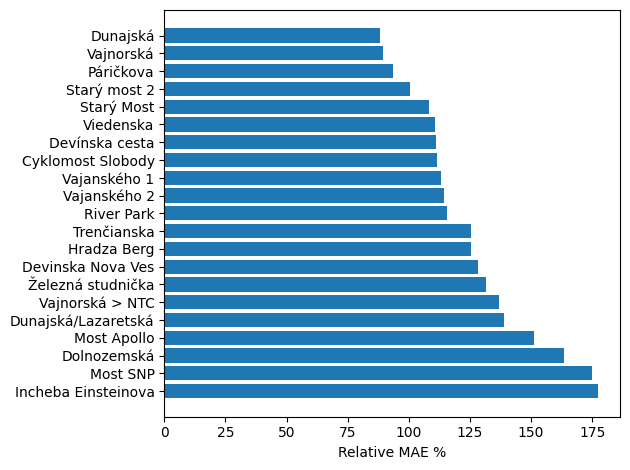

In [140]:
# Assume mae_lr, mae_ridge, mae_lasso are dicts
routes = list(mae_lr.keys())  # use one dict as reference

# Extract values in the same order as routes
lr_values = [mae_lr[r] for r in routes]
#ridge_values = [mae_ridge[r] for r in routes]
#lasso_values = [mae_lasso[r] for r in routes]

y = np.arange(len(routes))
height = 0.25

# Plot grouped bars
#plt.barh(y - height, lr_values, height=height, label='Linear Regression')
plt.barh(y, lr_values, label='RIDGE')
#plt.barh(y + height, lasso_values, height=height, label='LASSO')

plt.yticks(y, routes)
plt.xlabel("Relative MAE %")
#plt.legend()
plt.tight_layout()
plt.show()